In [3]:
'''!pip install finance-datareader
import FinanceDataReader as fdr
df = fdr.DataReader('AAPL', '2023')'''

In [48]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
#https://financedata.github.io/posts/finance-data-reader-users-guide.html

In [4]:
import pandas as pd
def make_code(x):
    x = str(x)
    return '0'*(6-len(x)) + x

code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download',header=0)[0]
code_data['종목코드'] = code_data['종목코드'].apply(make_code)
code_list = code_data[code_data['상장일'] < '2017-01-01']['종목코드']
code_data.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,095570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
2,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
3,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,DS단석,017860,기타 화학제품 제조업,바이오에너지,2023-12-22,12월,한승욱,http://dsdansuk.com,경기도


In [80]:
import FinanceDataReader as fdr
df = fdr.DataReader('034220', start = '2021-06-01', end = '2023')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-12-23,12700,12800,12600,12700,680253,-0.023077
2022-12-26,12750,13000,12500,12600,1243789,-0.007874
2022-12-27,12650,13000,12650,12900,1064909,0.023810
2022-12-28,12650,12850,12550,12650,938470,-0.019380
2022-12-29,12500,12650,12400,12450,860698,-0.015810


<Axes: xlabel='Date'>

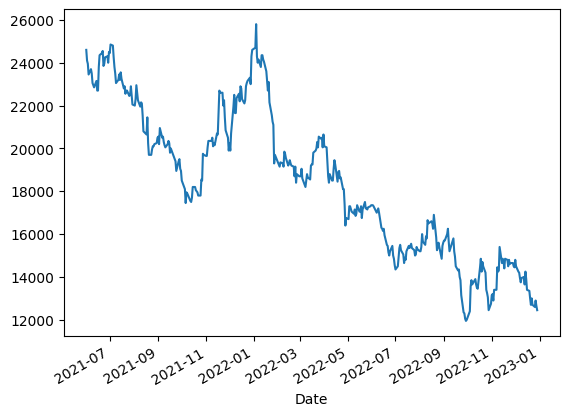

In [27]:
df['Close'].plot()

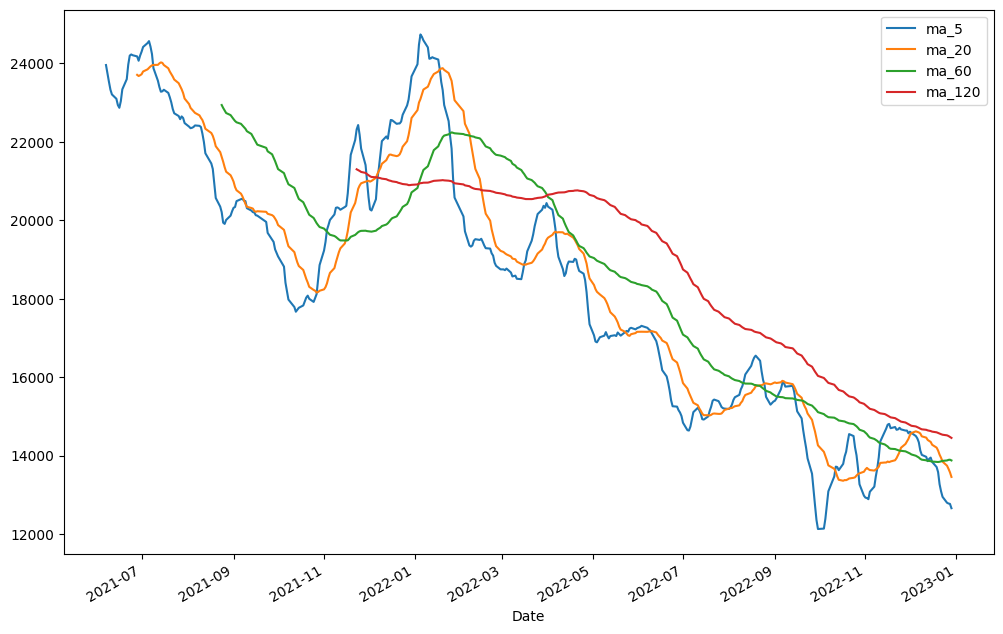

In [81]:
ma = [5, 20, 60, 120]
stock_df = df


for days in ma:
    stock_df['ma_'+str(days)] = df['Close'].rolling(window = days).mean()

plt.figure(figsize=(12,8))
for days in ma:
    stock_df['ma_'+str(days)].plot()
    plt.legend()

In [43]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [45]:
len(df)

393

In [82]:
df = pd.DataFrame(df['Close'])
df.head()

,Close
Date,
2021-06-01,24600
2021-06-02,24100
2021-06-03,23950
2021-06-04,23450
2021-06-07,23700


In [83]:
#한달치 data
len_month = 30

train = df.iloc[:-len_month]
test = df.iloc[-len_month:]

In [84]:
 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [85]:
scaled_train = scaled_train.reshape(-1)
scaled_test = scaled_test.reshape(-1)
print(scaled_train.shape)
print(scaled_test.shape)

(363,)
(30,)


In [86]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()

	for i in range(len(sequence)):
		end_ix = i + n_steps

		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)

	return np.array(X), np.array(y)

In [197]:
len_week = 7

n_steps = len_week #일주일치 데이터
n_features = 1  #단변량 데이터

x_train, y_train = split_sequence(scaled_train, n_steps)
x_test, y_test = split_sequence(scaled_test, n_steps)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(356, 7) (356,)
(23, 7) (23,)


In [88]:
x_train[0]

array([0.9133574 , 0.87725632, 0.86642599, 0.83032491, 0.84837545,
       0.83393502, 0.80144404])

In [89]:
pd.DataFrame(y_train.T,
             index = [f'output_{x+1}' for x in range(y_train.shape[0])],
             columns = [f'day1'])


,day1
output_1,0.794224
output_2,0.787004
output_3,0.808664
output_4,0.776173
output_5,0.776173
...,...
output_352,0.249097
output_353,0.194946
output_354,0.209386
output_355,0.202166


In [95]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))

model.add(LSTM(units = 64))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [96]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
#모델의 val_loss가 10epoch 동안 동일하면 학습을 중단

history = model.fit(x_train, y_train, epochs=30, callbacks=[early_stopping])


Epoch 1/30
12/12 [==============================] - 3s 17ms/step - loss: 0.1614 - mae: 0.3363
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0249 - mae: 0.1374
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0158 - mae: 0.0996
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.0073 - mae: 0.0686
Epoch 5/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0037 - mae: 0.0470
Epoch 6/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0040 - mae: 0.0510
Epoch 7/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0439
Epoch 8/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0033 - mae: 0.0444
Epoch 9/30
12/12 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0437
Epoch 10/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0432
Epoch 11/30
12/12 [==============================] - 0s 14m

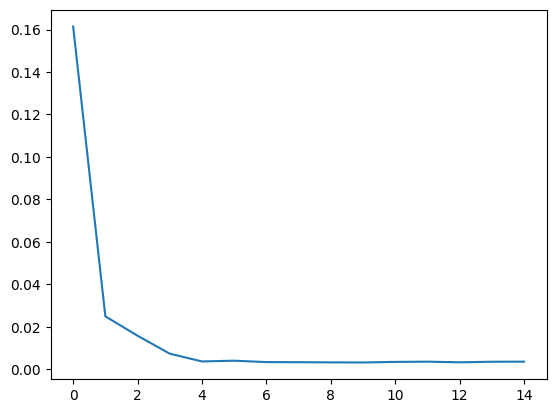

In [98]:
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), model.history.history['loss'])

In [107]:
from sklearn.metrics import mean_squared_error

In [198]:
# tratrainPredict = scaler.inverse_transform(trainPredict)
#train값과 test값 예측
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# rmse 계산
trainScore = mean_squared_error(train_predict, y_train)
print('Train Score: %.5f MSE' % (trainScore))
testScore = mean_squared_error(test_predict, y_test)
print('Test Score: %.5f MSE' % (testScore))

1/1 [==============================] - 0s 36ms/step
Train Score: 0.00310 MSE
Test Score: 0.00170 MSE


In [199]:
y_test = y_test.reshape(-1,1)
y_test.shape

(23, 1)

In [200]:
# 역정규화 과정
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [194]:
y_test.shape

(1, 23)

In [195]:
test_predict.shape

(23, 1)

<Axes: >

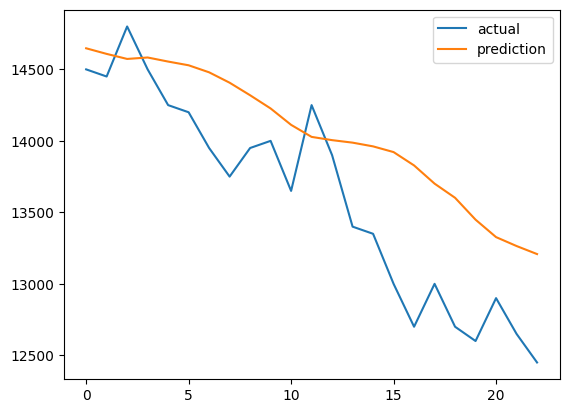

In [201]:
val_test  = pd.DataFrame() #예측값 검증을 위한 df 생성

y_test = pd.DataFrame(y_test)
#val_test.index = y_test.index #실제 test 범위에 해당하는 index 매칭

val_test['actual'] = y_test #실제 값 할당
val_test['prediction'] = test_predict #예측한 값 할당

val_test.plot()